In [1]:
%matplotlib inline
from numba import jit
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

import time

from tqdm import tqdm_notebook as tqdm

plt.style.use("./plotting/matplotlibrc")


mpl.rcParams['figure.dpi'] = 92

textwidth = 5.5532

## Model Description

### Elements of the Model

$\epsilon_{\rm \mu y},\epsilon_{\rm \sigma y},\epsilon_{\rm \mu x},\epsilon_{\rm \sigma x},\epsilon_{\rm a},\epsilon_{\rm b} \in \mathbb{R}$

$u\in \mathbb{R}^T$

$\mu_{\rm y t}\in \mathbb{R}^N$

$e,w_{\rm in},x,y,\mu_{\rm y},\sigma^2_{\rm y},\mu_{\rm x},\sigma^2_{\rm x},\sigma^2_{\rm y mf},a,b \in \mathbb{R}^{N\times T}$

$W \in \mathbb{R}^{N\times N}$

### Dynamics

\begin{align}
e_i(t) &= u(t) w_{{\rm in},i} \\
x_i(t) &= \sum_j W_{ij} y_j(t-1) \\
y_i(t) &= \mathrm{tanh}\left\{a_i(t-1) x_i(t)  + e_i(t) - b_i(t-1)\right\} \\
\mu_{{\rm y},i}(t) &= (1-\epsilon_{\rm \mu y})\mu_{{\rm y},i}(t-1) + \epsilon_{\rm \mu y} y_i(t) \\
\sigma^2_{{\rm y},i}(t) &= (1-\epsilon_{\rm \sigma y})\sigma^2_{{\rm y},i}(t-1) + \epsilon_{\rm \sigma y}\left( y_i(t) -   \mu_{{\rm y},i}(t) \right)^2 \\
\mu_{{\rm x},i}(t) &= (1-\epsilon_{\rm \mu x})\mu_{{\rm x},i}(t-1) + \epsilon_{\rm \mu x} x_i(t) \\
\sigma^2_{{\rm x},i}(t) &= (1-\epsilon_{\rm \sigma x})\sigma^2_{{\rm x},i}(t-1) + \epsilon_{\rm \sigma x}\left( x_i(t) -   \mu_{{\rm x},i}(t) \right)^2 \\
\sigma^2_{{\rm y mf},i}(t) &= (1-\alpha) \sigma^2_{{\rm y},i}(t) + \alpha \left\langle \sigma^2_{{\rm y},j}(t) \right\rangle_j \\
a_i(t) &= \left(1-\epsilon_{\rm a}\right) a_i(t-1) + \epsilon_{\rm a} R \sqrt{\sigma^2_{{\rm y mf},i}(t)/\sigma^2_{{\rm x},i}(t)} \\
b_i(t) &= b_i(t-1) + \epsilon_{\rm b} \left( y_i(t) - \mu_{{\rm y t},i}\right)
\end{align}

### Distributions

\begin{align}
p(W_{ij}) &= \begin{cases}
\delta(W_{ij}) &\mathrm{for} & i=j\\
(1-p_{\rm W})\delta(W_{ij}) + p_{\rm W} \mathcal{N}\left(W_{ij},\mu=0,\sigma=\sigma_{\rm W}\sqrt{p_{\rm W} N}^{-1}\right)  &\mathrm{for} & i\neq j\\
\end{cases} \\
p(w_{{\rm in},i}) &= (1-p_{\rm w in})\delta(w_{{\rm in},i}) + p_{\rm w in} \mathcal{N}\left(w_{{\rm in},i},\mu=0,\sigma=1\right) \\
p(\mu_{{\rm y t},i}) &= \mathcal{N}\left(\mu_{{\rm y t},i},\mu=0,\sigma=\sigma_{\rm \mu y t}\right)
\end{align}

### Parameters

| $N$ | $T$ | $p_{\rm W}$ | $p_{\rm w in}$ | $\epsilon_{\rm \mu y}$ |  $\epsilon_{\rm \sigma y}$ | $\epsilon_{\rm \mu x}$ |  $\epsilon_{\rm \sigma x}$ | $\epsilon_{\rm a}$ | $\epsilon_{\rm b}$ | $\sigma_{\rm \mu y t}$ | $\alpha$ | $R$|
|-|-|-|-|-|-|-|-|-|-|-|-|-|
|$1000$|$15\cdot10^3$|$0.1$|$1.0$|$10^{-3}$ | $5\cdot10^{-3}$ | $10^{-3}$ | $5\cdot10^{-3}$ | $10^{-3}$ | $10^{-3}$ | $10^{-2}$ |$1.0$|$1.0$|

The values/properties of $u$,$R$ and $\sigma_{\rm W}$ were left open to experimentation. Generally, the goal of the mechanism was to adapt $a$ in such a way that too large/too small variances in $W$ are compensated, leading to a spectral radius of $\rho\left(a_i W_{ij}\right)$ of $R$. We tested with $u$ taken from a Gaussian distribution with $1/4$ standard deviation, $R=1$ and $\sigma_{\rm W} = 2$. The latter initially caused the spectral radius to be 5.

Gains were initially set to $1$, biases to $0$.

In [12]:
def sim_loop(nt,
             E_sequ,
             N=1000,
             cf=.1,
             W_gen = np.random.normal,
             sigm_w = 2.,
             cf_in=1.,
             w_in_gen = np.random.normal,
             sigm_w_in = 1.,
             eps_a = 0.001,
             eps_b = 0.001,
             eps_var_y = 0.005,
             eps_var_X = 0.005,
             eps_mu_y = 0.001,
             eps_mu_X = 0.001,
             alpha_mf = 1.,
             mu_y_target_gen = np.random.normal,
            sigm_mu_y_target = 0.01,
            R=1.):
    
    ### Initialization
    
    ## Recurrent Weights
    W =  W_gen(0.,sigm_w/(cf*N)**.5,(N,N))*(np.random.rand(N,N) <= cf)
    ## No self-connection
    W[range(N),range(N)] = 0.
    
    ##  w_in
    w_in = w_in_gen(0.,sigm_w_in,(N))*(np.random.rand(N)<=cf_in)
    
    ### Generate Node Input
    E = np.outer(E_sequ,w_in)
    
    ### Targeted mean Activity
    mu_y_target = mu_y_target_gen(0.,0.01,(N))
        
    
    y = np.zeros((nt,N))
    X = np.zeros((nt,N))
    
    # Init y in a random state
    y[0,:] = (np.random.rand(N)-.5)*2.
    
    
    X[0,:] = np.zeros(N)
        
    var_y = np.ones((nt,N))
    var_X = np.ones((nt,N))
    
    mu_y = np.zeros((nt,N))
    mu_X = np.zeros((nt,N))
    
    a = np.ones((nt,N))
    
    b = np.zeros((nt,N))
    
    t_ax = np.arange(nt)
    
    for t in tqdm(range(1,nt)):
        
                
        X[t,:] = W.dot(y[t-1,:])
        
        y[t,:] = np.tanh(a[t-1,:]*X[t,:] + E[t,:] - b[t-1,:])
        
        mu_y[t,:] = mu_y[t-1,:]*(1.-eps_mu_y) + eps_mu_y*y[t,:]
        
        mu_X[t,:] = mu_X[t-1,:]*(1.-eps_mu_X) + eps_mu_X*X[t,:]
        
        var_y[t,:] = var_y[t-1,:]*(1.-eps_var_y) + eps_var_y*((y[t,:]-mu_y[t,:])**2.)

        var_X[t,:] = var_X[t-1,:]*(1.-eps_var_X) + eps_var_y*((X[t,:]-mu_X[t,:])**2.)

        var_y_mean_field = (1.-alpha_mf)*var_y[t,:] + alpha_mf*var_y[t,:].mean()

        a[t,:] = a[t-1,:]*(1.-eps_a) + eps_a * R*(var_y_mean_field/var_X[t,:])**.5
    
        b[t,:] = b[t-1,:] + eps_b * (y[t,:] - mu_y_target)
    
    return t_ax, y, X, var_y, var_X, a, b, W, w_in, mu_y_target

In [33]:
# Input sequence Normal Distribution
E_sequ = np.random.normal(0.,1.,(nt))*.25

# Input Sequence Binary (-1,1)
E_sequ_bin = (1.*(np.random.rand(nt)<=0.5)-.5)*2.*0.25

## Results

In [14]:
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

save_dpi = 1000

### For a Gaussian Sequence

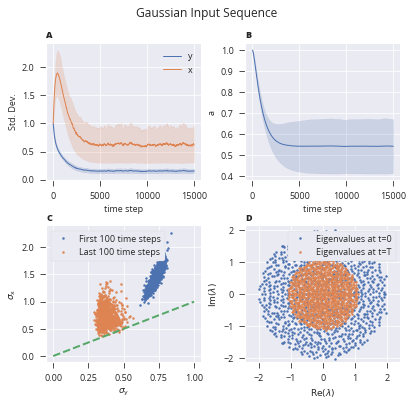

In [31]:
t_ax,y,X,vy,vX,a,b,W,w_in,mu_y_target = sim_loop(nt,E_sequ)

fig, ax =  plt.subplots(2,2,figsize=(textwidth,textwidth))



### ax0
vy_m = vy.mean(axis=1)
vy_std = vy.std(axis=1)

vX_m = vX.mean(axis=1)
vX_std = vX.std(axis=1)

ax[0,0].fill_between(t_ax[::10],vy_m[::10]-vy_std[::10],vy_m[::10]+vy_std[::10],color=colors[0],alpha=0.2)
ax[0,0].plot(t_ax[::10],vy_m[::10],c=colors[0],label="y")

ax[0,0].fill_between(t_ax[::10],vX_m[::10]-vX_std[::10],vX_m[::10]+vX_std[::10],color=colors[1],alpha=0.2)
ax[0,0].plot(t_ax[::10],vX_m[::10],c=colors[1],label="x")

ax[0,0].set_xlabel("time step")
ax[0,0].set_ylabel("Std. Dev.")

ax[0,0].legend()

ax[0,0].set_title("A",loc="left",fontdict={'fontweight':'bold'})
###

### ax1
a_m = a.mean(axis=1)
a_std = a.std(axis=1)

ax[0,1].fill_between(t_ax[::10],a_m[::10]-a_std[::10],a_m[::10]+a_std[::10],color=colors[0],alpha=0.2)
ax[0,1].plot(t_ax[::10],a_m[::10],c=colors[0],label="a")

ax[0,1].set_xlabel("time step")
ax[0,1].set_ylabel("a")

ax[0,1].set_title("B",loc="left",fontdict={'fontweight':'bold'})
###

### ax2
sy0 = y[:100,:].std(axis=0)
sx0 = X[:100,:].std(axis=0)

sy1 = y[-100:,:].std(axis=0)
sx1 = X[-100:,:].std(axis=0)

ax[1,0].plot(sy0,sx0,'.',markersize=5,label="First 100 time steps")
ax[1,0].plot(sy1,sx1,'.',markersize=5,label="Last 100 time steps")
ax[1,0].set_xlabel("$\\sigma_{\\rm y}$")
ax[1,0].set_ylabel("$\\sigma_{\\rm x}$")
ax[1,0].plot([0.,1.],[0.,1.],'--',lw=2)
ax[1,0].legend(frameon=True,framealpha=1.)

ax[1,0].set_title("C",loc="left",fontdict={'fontweight':'bold'})
###

### ax3
l1 = np.linalg.eigvals((W.T * a[0,:]).T)
l2 = np.linalg.eigvals((W.T * a[-1,:]).T)

ax[1,1].plot(l1.real,l1.imag,'.',markersize=5,label="Eigenvalues at t=0")
ax[1,1].plot(l2.real,l2.imag,'.',markersize=5,label="Eigenvalues at t=T")
ax[1,1].axis("equal")

ax[1,1].set_xlabel("$\\mathrm{Re}(\\lambda)$")
ax[1,1].set_ylabel("$\\mathrm{Im}(\\lambda)$")

ax[1,1].legend(frameon=True,framealpha=1.)

ax[1,1].set_title("D",loc="left",fontdict={'fontweight':'bold'})
###

fig.suptitle("Gaussian Input Sequence")

fig.tight_layout(pad=0.,rect=[0, 0., 1., 0.92])

plt.savefig("../plots/alternative_mech/composite.png",dpi=save_dpi)
plt.savefig("../plots/alternative_mech/composite.pdf")

plt.show()

### For a Binary Sequence

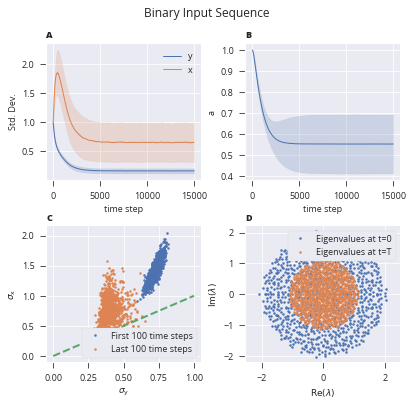

In [34]:
t_ax,y,X,vy,vX,a,b,W,w_in,mu_y_target = sim_loop(nt,E_sequ_bin)

fig, ax =  plt.subplots(2,2,figsize=(textwidth,textwidth))

### ax0
vy_m = vy.mean(axis=1)
vy_std = vy.std(axis=1)

vX_m = vX.mean(axis=1)
vX_std = vX.std(axis=1)

ax[0,0].fill_between(t_ax[::10],vy_m[::10]-vy_std[::10],vy_m[::10]+vy_std[::10],color=colors[0],alpha=0.2)
ax[0,0].plot(t_ax[::10],vy_m[::10],c=colors[0],label="y")

ax[0,0].fill_between(t_ax[::10],vX_m[::10]-vX_std[::10],vX_m[::10]+vX_std[::10],color=colors[1],alpha=0.2)
ax[0,0].plot(t_ax[::10],vX_m[::10],c=colors[1],label="x")

ax[0,0].set_xlabel("time step")
ax[0,0].set_ylabel("Std. Dev.")

ax[0,0].legend()

ax[0,0].set_title("A",loc="left",fontdict={'fontweight':'bold'})
###

### ax1
a_m = a.mean(axis=1)
a_std = a.std(axis=1)

ax[0,1].fill_between(t_ax[::10],a_m[::10]-a_std[::10],a_m[::10]+a_std[::10],color=colors[0],alpha=0.2)
ax[0,1].plot(t_ax[::10],a_m[::10],c=colors[0],label="a")

ax[0,1].set_xlabel("time step")
ax[0,1].set_ylabel("a")

ax[0,1].set_title("B",loc="left",fontdict={'fontweight':'bold'})
###

### ax2
sy0 = y[:100,:].std(axis=0)
sx0 = X[:100,:].std(axis=0)

sy1 = y[-100:,:].std(axis=0)
sx1 = X[-100:,:].std(axis=0)

ax[1,0].plot(sy0,sx0,'.',markersize=5,label="First 100 time steps")
ax[1,0].plot(sy1,sx1,'.',markersize=5,label="Last 100 time steps")
ax[1,0].set_xlabel("$\\sigma_{\\rm y}$")
ax[1,0].set_ylabel("$\\sigma_{\\rm x}$")
ax[1,0].plot([0.,1.],[0.,1.],'--',lw=2)
ax[1,0].legend(frameon=True,framealpha=1.)

ax[1,0].set_title("C",loc="left",fontdict={'fontweight':'bold'})
###

### ax3
l1 = np.linalg.eigvals((W.T * a[0,:]).T)
l2 = np.linalg.eigvals((W.T * a[-1,:]).T)

ax[1,1].plot(l1.real,l1.imag,'.',markersize=5,label="Eigenvalues at t=0")
ax[1,1].plot(l2.real,l2.imag,'.',markersize=5,label="Eigenvalues at t=T")
ax[1,1].axis("equal")

ax[1,1].set_xlabel("$\\mathrm{Re}(\\lambda)$")
ax[1,1].set_ylabel("$\\mathrm{Im}(\\lambda)$")

ax[1,1].legend(frameon=True,framealpha=1.)

ax[1,1].set_title("D",loc="left",fontdict={'fontweight':'bold'})
###

fig.suptitle("Binary Input Sequence")

fig.tight_layout(pad=0.,rect=[0, 0., 1., 0.92])

plt.savefig("../plots/alternative_mech/composite_binary_sequ.png",dpi=save_dpi)
plt.savefig("../plots/alternative_mech/composite_binary_sequ.pdf")

plt.show()

### For a Gaussian Sequence, Binary Recurrent Weight Matrix

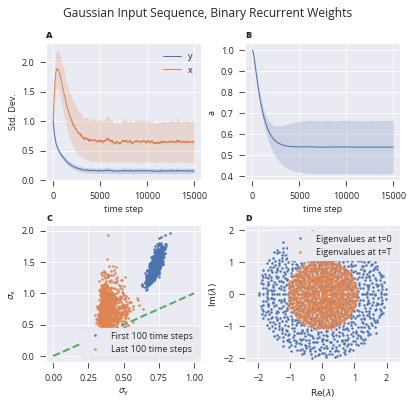

In [37]:
def binary_w(mean,std,size):
    
    return ((np.random.random_sample(size) <= 0.5)*1. -.5)*2.*std + mean


t_ax,y,X,vy,vX,a,b,W,w_in,mu_y_target = sim_loop(nt,E_sequ,W_gen=binary_w)

fig, ax =  plt.subplots(2,2,figsize=(textwidth,textwidth))

### ax0
vy_m = vy.mean(axis=1)
vy_std = vy.std(axis=1)

vX_m = vX.mean(axis=1)
vX_std = vX.std(axis=1)

ax[0,0].fill_between(t_ax[::10],vy_m[::10]-vy_std[::10],vy_m[::10]+vy_std[::10],color=colors[0],alpha=0.2)
ax[0,0].plot(t_ax[::10],vy_m[::10],c=colors[0],label="y")

ax[0,0].fill_between(t_ax[::10],vX_m[::10]-vX_std[::10],vX_m[::10]+vX_std[::10],color=colors[1],alpha=0.2)
ax[0,0].plot(t_ax[::10],vX_m[::10],c=colors[1],label="x")

ax[0,0].set_xlabel("time step")
ax[0,0].set_ylabel("Std. Dev.")

ax[0,0].legend()

ax[0,0].set_title("A",loc="left",fontdict={'fontweight':'bold'})
###

### ax1
a_m = a.mean(axis=1)
a_std = a.std(axis=1)

ax[0,1].fill_between(t_ax[::10],a_m[::10]-a_std[::10],a_m[::10]+a_std[::10],color=colors[0],alpha=0.2)
ax[0,1].plot(t_ax[::10],a_m[::10],c=colors[0],label="a")

ax[0,1].set_xlabel("time step")
ax[0,1].set_ylabel("a")

ax[0,1].set_title("B",loc="left",fontdict={'fontweight':'bold'})
###

### ax2
sy0 = y[:100,:].std(axis=0)
sx0 = X[:100,:].std(axis=0)

sy1 = y[-100:,:].std(axis=0)
sx1 = X[-100:,:].std(axis=0)

ax[1,0].plot(sy0,sx0,'.',markersize=5,label="First 100 time steps")
ax[1,0].plot(sy1,sx1,'.',markersize=5,label="Last 100 time steps")
ax[1,0].set_xlabel("$\\sigma_{\\rm y}$")
ax[1,0].set_ylabel("$\\sigma_{\\rm x}$")
ax[1,0].plot([0.,1.],[0.,1.],'--',lw=2)
ax[1,0].legend(frameon=True,framealpha=1.)

ax[1,0].set_title("C",loc="left",fontdict={'fontweight':'bold'})
###

### ax3
l1 = np.linalg.eigvals((W.T * a[0,:]).T)
l2 = np.linalg.eigvals((W.T * a[-1,:]).T)

ax[1,1].plot(l1.real,l1.imag,'.',markersize=5,label="Eigenvalues at t=0")
ax[1,1].plot(l2.real,l2.imag,'.',markersize=5,label="Eigenvalues at t=T")
ax[1,1].axis("equal")

ax[1,1].set_xlabel("$\\mathrm{Re}(\\lambda)$")
ax[1,1].set_ylabel("$\\mathrm{Im}(\\lambda)$")

ax[1,1].legend(frameon=True,framealpha=1.)

ax[1,1].set_title("D",loc="left",fontdict={'fontweight':'bold'})
###

fig.suptitle("Gaussian Input Sequence, Binary Recurrent Weights")

fig.tight_layout(pad=0.,rect=[0, 0., 1., 0.92])

plt.savefig("../plots/alternative_mech/composite_binary_matrix.png",dpi=save_dpi)
plt.savefig("../plots/alternative_mech/composite_binary_matrix.pdf")

plt.show()

### For a Binary Sequence, Binary Recurrent Weight Matrix

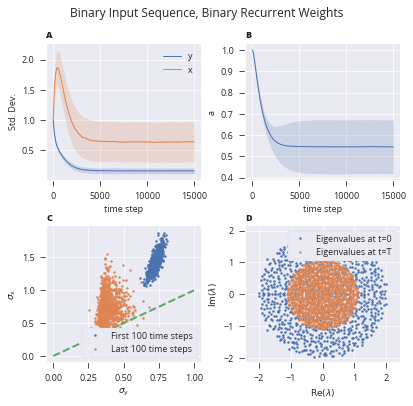

In [39]:
def binary_w(mean,std,size):
    
    return ((np.random.random_sample(size) <= 0.5)*1. -.5)*2.*std + mean


t_ax,y,X,vy,vX,a,b,W,w_in,mu_y_target = sim_loop(nt,E_sequ_bin,W_gen=binary_w)

fig, ax =  plt.subplots(2,2,figsize=(textwidth,textwidth))

### ax0
vy_m = vy.mean(axis=1)
vy_std = vy.std(axis=1)

vX_m = vX.mean(axis=1)
vX_std = vX.std(axis=1)

ax[0,0].fill_between(t_ax[::10],vy_m[::10]-vy_std[::10],vy_m[::10]+vy_std[::10],color=colors[0],alpha=0.2)
ax[0,0].plot(t_ax[::10],vy_m[::10],c=colors[0],label="y")

ax[0,0].fill_between(t_ax[::10],vX_m[::10]-vX_std[::10],vX_m[::10]+vX_std[::10],color=colors[1],alpha=0.2)
ax[0,0].plot(t_ax[::10],vX_m[::10],c=colors[1],label="x")

ax[0,0].set_xlabel("time step")
ax[0,0].set_ylabel("Std. Dev.")

ax[0,0].legend()

ax[0,0].set_title("A",loc="left",fontdict={'fontweight':'bold'})
###

### ax1
a_m = a.mean(axis=1)
a_std = a.std(axis=1)

ax[0,1].fill_between(t_ax[::10],a_m[::10]-a_std[::10],a_m[::10]+a_std[::10],color=colors[0],alpha=0.2)
ax[0,1].plot(t_ax[::10],a_m[::10],c=colors[0],label="a")

ax[0,1].set_xlabel("time step")
ax[0,1].set_ylabel("a")

ax[0,1].set_title("B",loc="left",fontdict={'fontweight':'bold'})
###

### ax2
sy0 = y[:100,:].std(axis=0)
sx0 = X[:100,:].std(axis=0)

sy1 = y[-100:,:].std(axis=0)
sx1 = X[-100:,:].std(axis=0)

ax[1,0].plot(sy0,sx0,'.',markersize=5,label="First 100 time steps")
ax[1,0].plot(sy1,sx1,'.',markersize=5,label="Last 100 time steps")
ax[1,0].set_xlabel("$\\sigma_{\\rm y}$")
ax[1,0].set_ylabel("$\\sigma_{\\rm x}$")
ax[1,0].plot([0.,1.],[0.,1.],'--',lw=2)
ax[1,0].legend(frameon=True,framealpha=1.)

ax[1,0].set_title("C",loc="left",fontdict={'fontweight':'bold'})
###

### ax3
l1 = np.linalg.eigvals((W.T * a[0,:]).T)
l2 = np.linalg.eigvals((W.T * a[-1,:]).T)

ax[1,1].plot(l1.real,l1.imag,'.',markersize=5,label="Eigenvalues at t=0")
ax[1,1].plot(l2.real,l2.imag,'.',markersize=5,label="Eigenvalues at t=T")
ax[1,1].axis("equal")

ax[1,1].set_xlabel("$\\mathrm{Re}(\\lambda)$")
ax[1,1].set_ylabel("$\\mathrm{Im}(\\lambda)$")

ax[1,1].legend(frameon=True,framealpha=1.)

ax[1,1].set_title("D",loc="left",fontdict={'fontweight':'bold'})
###

fig.suptitle("Binary Input Sequence, Binary Recurrent Weights")

fig.tight_layout(pad=0.,rect=[0, 0., 1., 0.92])

plt.savefig("../plots/alternative_mech/composite_binary_matrix_binary_sequence.png",dpi=save_dpi)
plt.savefig("../plots/alternative_mech/composite_binary_matrix_binary_sequence.pdf")

plt.show()